In [14]:
from pathlib import Path

ROOT = Path.cwd().parent
MARKINGS_DATA = Path(f"{ROOT}/data/markings_data")
IMAGES = Path(f"{ROOT}/data/perspective_frames")

# Class mapping for YOLO (must match labeling names exactly)
CLASS_TO_ID = {
    "arrow": 0,
    "dot": 1,
}

# Common image extensions 
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

print("DIRS:", MARKINGS_DATA, "\n", IMAGES)
print("Exists:", MARKINGS_DATA.exists(), IMAGES.exists())
print("Class mapping:", CLASS_TO_ID)

DIRS: /Users/jleto/LocalProjects/rev_vision/data/markings_data 
 /Users/jleto/LocalProjects/rev_vision/data/perspective_frames
Exists: True True
Class mapping: {'arrow': 0, 'dot': 1}


In [24]:
# Find images with matching LabelMe JSON files

images = []
annotations = []

for p in IMAGES.iterdir():
    if p.suffix.lower() in IMG_EXTS:
        json_path = Path(MARKINGS_DATA) / f"{p.stem}.json"
        # print(json_path)
        if json_path.exists():
            print(p, json_path)
            images.append(p)
            annotations.append(json_path)

print(f"Found {len(images)} images with matching annotations")

/Users/jleto/LocalProjects/rev_vision/data/perspective_frames/frame_1120.png /Users/jleto/LocalProjects/rev_vision/data/markings_data/frame_1120.json
/Users/jleto/LocalProjects/rev_vision/data/perspective_frames/frame_1054.png /Users/jleto/LocalProjects/rev_vision/data/markings_data/frame_1054.json
/Users/jleto/LocalProjects/rev_vision/data/perspective_frames/frame_1097.png /Users/jleto/LocalProjects/rev_vision/data/markings_data/frame_1097.json
/Users/jleto/LocalProjects/rev_vision/data/perspective_frames/frame_1096.png /Users/jleto/LocalProjects/rev_vision/data/markings_data/frame_1096.json
/Users/jleto/LocalProjects/rev_vision/data/perspective_frames/frame_1055.png /Users/jleto/LocalProjects/rev_vision/data/markings_data/frame_1055.json
/Users/jleto/LocalProjects/rev_vision/data/perspective_frames/frame_1243.png /Users/jleto/LocalProjects/rev_vision/data/markings_data/frame_1243.json
/Users/jleto/LocalProjects/rev_vision/data/perspective_frames/frame_1121.png /Users/jleto/LocalProje

In [ ]:
# Inspect a single LabelMe JSON (demo)

import json

sample_json = annotations[4]

with open(sample_json, "r") as f:
    data = json.load(f)

print("Top-level keys:")
print(data.keys())

print("\nNumber of shapes:", len(data["shapes"]))

print("\nFirst shape example:")
print(data["shapes"][9])


Top-level keys:
dict_keys(['version', 'flags', 'shapes', 'imagePath', 'imageData', 'imageHeight', 'imageWidth'])

Number of shapes: 16

First shape example:
{'label': 'arrow', 'points': [[290.98966026587885, 436.4844903988183], [297.1935007385524, 449.77843426883305]], 'group_id': None, 'description': '', 'shape_type': 'rectangle', 'flags': {}}


In [33]:
# Convert a single LabelMe rectangle to YOLO format (demo)

shape = data["shapes"][0]

label = shape["label"]
(points_x1, points_y1), (points_x2, points_y2) = shape["points"]

# Image size (needed for normalization)
img_w = data["imageWidth"]
img_h = data["imageHeight"]

# Rectangle corners → width/height
x_min = min(points_x1, points_x2)
x_max = max(points_x1, points_x2)
y_min = min(points_y1, points_y2)
y_max = max(points_y1, points_y2)

# YOLO expects center-based boxes
x_center = (x_min + x_max) / 2.0
y_center = (y_min + y_max) / 2.0
box_w = x_max - x_min
box_h = y_max - y_min

# Normalize to [0, 1]
x_center /= img_w
y_center /= img_h
box_w /= img_w
box_h /= img_h

print("Label:", label)
print("YOLO box (x_center, y_center, w, h):")
print(x_center, y_center, box_w, box_h)

Label: dot
YOLO box (x_center, y_center, w, h):
0.1325921908893709 0.7763316461798023 0.01789587852494577 0.005302482525909858


/Users/jleto/LocalProjects/rev_vision/data/perspective_frames/frame_1055.png


(np.float64(-0.5), np.float64(399.5), np.float64(899.5), np.float64(-0.5))

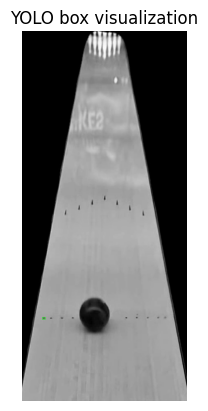

In [ ]:
# Visualize a single YOLO box with OpenCV (demo)

import cv2
import matplotlib.pyplot as plt

# Load the image
img_path = IMAGES / Path(data["imagePath"].replace("\\", "/")).name
print(img_path)

img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)

h, w = img.shape

# Convert YOLO back to pixel coords
x_c = x_center * w
y_c = y_center * h
bw = box_w * w
bh = box_h * h

x1 = int(x_c - bw / 2)
y1 = int(y_c - bh / 2)
x2 = int(x_c + bw / 2)
y2 = int(y_c + bh / 2)

# Draw rectangle
img_vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.rectangle(img_vis, (x1, y1), (x2, y2), (0, 255, 0), 1)

plt.imshow(img_vis, cmap="gray")
plt.title("YOLO box visualization")
plt.axis("off")

In [51]:
# Convert all LabelMe annotations to YOLO label files and save to disk

import json

# Where YOLO label files will go
LABELS_OUT = MARKINGS_DATA.parent / "yolo_labels"
LABELS_OUT.mkdir(exist_ok=True)

for img_path, json_path in zip(images, annotations):
    # Load annotation
    with open(json_path, "r") as f:
        data = json.load(f)

    img_w = data["imageWidth"]
    img_h = data["imageHeight"]

    yolo_lines = []

    for shape in data["shapes"]:
        label = shape["label"]

        # Skip anything not in our class map
        if label not in CLASS_TO_ID:
            continue

        # Rectangle points from LabelMe
        (x1, y1), (x2, y2) = shape["points"]

        # Normalize rectangle
        x_min = min(x1, x2)
        x_max = max(x1, x2)
        y_min = min(y1, y2)
        y_max = max(y1, y2)

        # Convert to YOLO format
        x_center = (x_min + x_max) / 2.0 / img_w
        y_center = (y_min + y_max) / 2.0 / img_h
        box_w = (x_max - x_min) / img_w
        box_h = (y_max - y_min) / img_h

        class_id = CLASS_TO_ID[label]

        yolo_lines.append(
            f"{class_id} {x_center:.6f} {y_center:.6f} {box_w:.6f} {box_h:.6f}"
        )

    # Write YOLO label file
    label_path = LABELS_OUT / f"{img_path.stem}.txt"
    with open(label_path, "w") as f:
        f.write("\n".join(yolo_lines))

In [52]:
# Sanity check YOLO label files

label_files = sorted(LABELS_OUT.glob("*.txt"))

num_labels = len(label_files)
num_empty = 0
num_nonempty = 0

for lf in label_files:
    if lf.stat().st_size == 0:
        num_empty += 1
    else:
        num_nonempty += 1

print("Total label files:", num_labels)
print("Non-empty labels:", num_nonempty)
print("Empty labels:", num_empty)

Total label files: 128
Non-empty labels: 128
Empty labels: 0


(np.float64(-0.5), np.float64(399.5), np.float64(899.5), np.float64(-0.5))

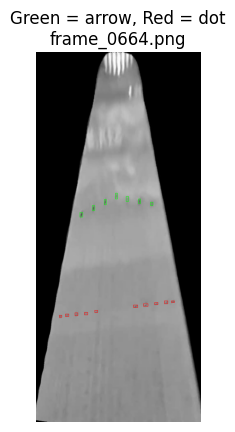

In [66]:
# Visual check: draw YOLO boxes on a random image

import random
import cv2
import matplotlib.pyplot as plt

# Pick a random labeled image
img_path = random.choice(images)
label_path = LABELS_OUT / f"{img_path.stem}.txt"

# Load image
img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
h, w = img.shape
img_vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Load labels
if label_path.exists():
    with open(label_path, "r") as f:
        lines = f.read().strip().splitlines()
else:
    lines = []

# Draw boxes
for line in lines:
    class_id, xc, yc, bw, bh = map(float, line.split())

    x_c = xc * w
    y_c = yc * h
    box_w = bw * w
    box_h = bh * h

    x1 = int(x_c - box_w / 2)
    y1 = int(y_c - box_h / 2)
    x2 = int(x_c + box_w / 2)
    y2 = int(y_c + box_h / 2)

    # green for arrows, red for dots
    color = (0, 255, 0) if int(class_id) == 0 else (255, 0, 0)
    cv2.rectangle(img_vis, (x1, y1), (x2, y2), color, 1)

plt.imshow(img_vis, cmap="gray")
plt.title(f"Green = arrow, Red = dot\n{img_path.name}")
plt.axis("off")

In [64]:
# Create YOLO dataset folder structure + train/val split

import random
import shutil

DATASET_OUT = MARKINGS_DATA.parent / "yolo_dataset"
IMG_OUT_TRAIN = DATASET_OUT / "images" / "train"
IMG_OUT_VAL   = DATASET_OUT / "images" / "val"
LBL_OUT_TRAIN = DATASET_OUT / "labels" / "train"
LBL_OUT_VAL   = DATASET_OUT / "labels" / "val"

for d in [IMG_OUT_TRAIN, IMG_OUT_VAL, LBL_OUT_TRAIN, LBL_OUT_VAL]:
    d.mkdir(parents=True, exist_ok=True)

pairs = [(img, LABELS_OUT / f"{img.stem}.txt") for img in images]

random.seed(42)
random.shuffle(pairs)

split_idx = int(0.8 * len(pairs))
train_pairs = pairs[:split_idx]
val_pairs = pairs[split_idx:]

def copy_pairs(pairs_list, img_dst, lbl_dst):
    for img_path, lbl_path in pairs_list:
        shutil.copy2(img_path, img_dst / img_path.name)
        shutil.copy2(lbl_path, lbl_dst / lbl_path.name)

copy_pairs(train_pairs, IMG_OUT_TRAIN, LBL_OUT_TRAIN)
copy_pairs(val_pairs, IMG_OUT_VAL, LBL_OUT_VAL)

print("Total:", len(pairs))
print("Train:", len(train_pairs))
print("Val:", len(val_pairs))
print("Dataset folder:", DATASET_OUT)

Total: 128
Train: 102
Val: 26
Dataset folder: /Users/jleto/LocalProjects/rev_vision/data/yolo_dataset


In [65]:
# Create YOLO data.yaml file

DATA_YAML = DATASET_OUT / "data.yaml"

yaml_text = f"""
path: {DATASET_OUT}
train: images/train
val: images/val

nc: 2
names:
  - arrow
  - dot
"""

with open(DATA_YAML, "w") as f:
    f.write(yaml_text.strip())

print("Wrote:", DATA_YAML)

Wrote: /Users/jleto/LocalProjects/rev_vision/data/yolo_dataset/data.yaml


In [67]:
# Train YOLOv8 on your dataset

from ultralytics import YOLO

model = YOLO("yolov8n.pt")

model.train(
    data=DATA_YAML,
    epochs=30,
    imgsz=640,
    batch=16,
    project=DATASET_OUT.parent,
    name="yolo_lane_markings",
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/Users/jleto/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.5.1 CPU (Apple M2)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/Users/jleto/LocalProjects/rev_vision/data/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x1649cbcb0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 


image 1/1 /Users/jleto/LocalProjects/rev_vision/data/perspective_frames/frame_1212.png: 640x288 4 arrows, 42.4ms
Speed: 0.9ms preprocess, 42.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 288)


(np.float64(-0.5), np.float64(399.5), np.float64(899.5), np.float64(-0.5))

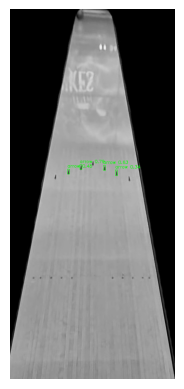

In [77]:
from ultralytics import YOLO

MODEL_PATH = DATASET_OUT.parent / "yolo_lane_markings" / "weights" / "best.pt"
model = YOLO(MODEL_PATH)

# Pick a test image
test_img = images[94]  # or change index

results = model.predict(
    source=test_img,
    conf=0.25,
    imgsz=640,
    save=False
)

# Show prediction
import matplotlib.pyplot as plt
import cv2

img = cv2.imread(str(test_img), cv2.IMREAD_GRAYSCALE)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

for r in results:
    for box in r.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cls = int(box.cls[0])
        conf = float(box.conf[0])

        color = (0, 255, 0) if cls == 0 else (255, 0, 0)
        label = f"{'arrow' if cls==0 else 'dot'} {conf:.2f}"

        cv2.rectangle(img, (x1, y1), (x2, y2), color, 1)
        cv2.putText(img, label, (x1, y1-4),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.35, color, 1)

plt.imshow(img, cmap="gray")
plt.axis("off")